In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import InterpolationMode
from torchvision import models
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import time
import copy
import os

# 0. Definições Iniciais

In [2]:
def set_device(on_gpu=True):
    has_mps = torch.backends.mps.is_available()
    has_cuda = torch.cuda.is_available()
    return "mps" if (has_mps and on_gpu) \
            else "cuda" if (has_cuda and on_gpu) \
            else "cpu"

In [3]:
device = set_device(on_gpu=True)

# 1. Carregamento de Dados

## 1.1 Definindo transformações

In [ ]:
ROOT_DIR = 'RiceLeafs'

# Definimos as transformações para os dados de treinamento.
train_transform = transforms.Compose([
    # Corta e redimensiona aleatoriamente a imagem para 224x224 pixels;
    # transforms.RandomResizedCrop(size=224, scale=(0.5, 1.0), interpolation=InterpolationMode.BICUBIC),
    transforms.Resize((300,300), interpolation=InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(p=0.5),                                      # Aplica flip horizontal aleatório;
    transforms.RandomChoice([                                                    # Escolhe aleatoriamente uma das rotações definidas:
        transforms.RandomRotation((0, 0)),                                          # Não gira (0 graus);
        transforms.RandomRotation((90, 90)),                                        # Gira exatamente 90 graus;
        transforms.RandomRotation((180, 180)),                                      # Gira exatamente 180 graus;
        transforms.RandomRotation((270, 270))                                       # Gira exatamente 270 graus;
    ]),                                      
    transforms.ColorJitter(brightness=0.1, contrast=0.1),                        # Ajusta brilho e contraste aleatoriamente; 
    transforms.ToTensor(),                                                       # Converte a imagem para um tensor PyTorch;     
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normaliza a imagem com médias e desvios padrão do ImageNet.
])

# As transformações de validação são apenas de redimensionamento e normalização.
val_transform = transforms.Compose([
    transforms.Resize((300,300), interpolation=InterpolationMode.BICUBIC),      # Redimensionar para 224x224;
    transforms.ToTensor(),                                                       # Converter para tensor;
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normaliza a imagem com médias e desvios padrão do ImageNet.
])                                              

## 1.2 Criando Datasets e DataLoaders

In [ ]:
# Para treino, usaremos 'RiceLeafs/train'
train_dataset = datasets.ImageFolder(
    root=os.path.join(ROOT_DIR, 'train'),
    transform=train_transform # Aplica as tranformações de treinamento  
)

# Para validação, usaremos 'RiceLeafs/validation'
val_dataset = datasets.ImageFolder(
    root=os.path.join(ROOT_DIR, 'validation'),
    transform=val_transform # Aplica as tranformações de validação do modelo
)

# Vamos salvar separadamente os nomes das classes para referência futura.
class_names = train_dataset.classes
NUM_CLASSES = len(class_names)
print(f"Classes carregadas: {class_names}")

# Criamos os DataLoaders com batch size de 32
BATCH_SIZE = 16

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=os.cpu_count() // 2 
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=os.cpu_count() // 2
)

Classes carregadas: ['BrownSpot', 'Healthy', 'Hispa', 'LeafBlast']


# 2. Escolha do modelo

In [ ]:
weights = models.EfficientNet_B3_Weights.IMAGENET1K_V1 # Definimos os pesos pré-treinados do ImageNet
model = models.efficientnet_b3(weights=weights)        # Carregamos o modelo EfficientNet-B0 pré-treinado

## 2.1 Alterando a camada final do modelo

In [ ]:
for param in model.parameters():    # Congelamos todos os parâmetros do modelo pré-treinado para evitar que sejam atualizados durante o treinamento
    param.requires_grad = False

# Modificamos a camada final para o número correto de classes
num_ftrs = model.classifier[1].in_features
model.classifier = nn.Sequential(    
    nn.Linear(in_features=num_ftrs, out_features=512),      # Camada Intermediária para processar as features
    nn.BatchNorm1d(num_features=512),                       # BatchNorm para estabilizar e acelerar o treinamento
    nn.ReLU(),                                              # Ativação não-linear
    nn.Dropout(p=0.4),                                      # Dropout agressivo para evitar overfitting
    nn.Linear(in_features=512, out_features=NUM_CLASSES)    # Camada Final (4 classes)
)

# Mover o modelo para o dispositivo
model.to(device)
print(f"Dispositivo do modelo: {next(model.parameters()).device}")

Dispositivo do modelo: cuda:0


# 3. Treinamento

In [ ]:
criterion = nn.CrossEntropyLoss()                                             # Função de perda para classificação multi-classe
L2_LAMBDA = 0.0001                                                            # Fator de regularização L2                                                          # Fator de regularização L1    
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=L2_LAMBDA)  # Otimizador Adam com regularização L2

## 3.1 Loop de Treino

In [ ]:
history = {'train_loss': [], # Histórico de perda de treinamento
            'train_acc': [], # Histórico de acurácia de treinamento
            'val_loss': [],  # Histórico de perda de validação
            'val_acc': []}   # Histórico de acurácia de validação

def train_model(model, criterion, optimizer, train_loader, num_epochs=10):
    start_time = time.time() # Início do cronômetro
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        model.train() # Modo de treinamento
                
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zera gradientes do otimizador
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Backward pass e otimização
            loss.backward()
            optimizer.step()

            # Estatísticas
            running_loss += loss.item() * BATCH_SIZE
            running_corrects += torch.sum(preds == labels.data).item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects / len(train_loader.dataset)

        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)
    
    time_elapsed = time.time() - start_time
    print(f'Treino concluído em {time_elapsed // 60:.0f}min {time_elapsed % 60:.0f}s')
    print(f'Acurácia final de treinamento: {history["train_acc"][-1]:.4f}')

    return model

In [10]:
trained_model = train_model(model, criterion, optimizer, train_loader, num_epochs=10)

Epoch 1/10
----------
Epoch 2/10
----------
Epoch 3/10
----------
Epoch 4/10
----------
Epoch 5/10
----------
Epoch 6/10
----------
Epoch 7/10
----------
Epoch 8/10
----------
Epoch 9/10
----------
Epoch 10/10
----------
Treino concluído em 11min 56s
Acurácia final de treinamento: 0.6514


## 3.2 Fine-Tunning

In [16]:
for param in model.parameters():    # Descongelamos todos os parâmetros do modelo para permitir o fine-tuning
    param.requires_grad = True
 
optimizer_ft = optim.Adam(model.parameters(), lr=0.0001) # Otimizador Adam para todo o modelo com uma taxa de aprendizado menor

print("Iniciando o fine-tuning do modelo...")
trained_model = train_model(model, criterion, optimizer_ft, train_loader, num_epochs=10)

Iniciando o fine-tuning do modelo...
Epoch 1/10
----------
Epoch 2/10
----------
Epoch 3/10
----------
Epoch 4/10
----------
Epoch 5/10
----------
Epoch 6/10
----------
Epoch 7/10
----------
Epoch 8/10
----------
Epoch 9/10
----------
Epoch 10/10
----------
Treino concluído em 13min 30s
Acurácia final de treinamento: 0.9277


# 4. Validação

In [17]:
def validate_model(model, val_loader, criterion, num_epochs=10):

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    model.eval()

    start_time = time.time()
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        val_running_loss = 0.0
        val_running_corrects = 0

        with torch.no_grad(): # Desliga cálculo de gradientes para validação
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)

        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_running_corrects.double() / len(val_loader.dataset)

        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc.item())

        # Guardar o modelo se for o melhor até agora
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - start_time
    print(f'Validação concluída em {time_elapsed // 60:.0f}min {time_elapsed % 60:.0f}s')
    print(f'Melhor Acurácia de Validação: {best_acc:.4f}')

    # Carregar os melhores pesos no modelo final
    model.load_state_dict(best_model_wts)
    return model

In [18]:
trained_model = validate_model(trained_model, val_loader, criterion, num_epochs=10)

Epoch 1/10
----------


Epoch 2/10
----------
Epoch 3/10
----------
Epoch 4/10
----------
Epoch 5/10
----------
Epoch 6/10
----------
Epoch 7/10
----------
Epoch 8/10
----------
Epoch 9/10
----------
Epoch 10/10
----------
Validação concluída em 2min 11s
Melhor Acurácia de Validação: 0.3770


Gerando previsões para o conjunto de validação...

--- Relatório de Classificação ---
              precision    recall  f1-score   support

   BrownSpot       0.18      0.24      0.20       105
     Healthy       0.68      0.43      0.53       297
       Hispa       0.55      0.14      0.23       113
   LeafBlast       0.27      0.54      0.36       156

    accuracy                           0.38       671
   macro avg       0.42      0.34      0.33       671
weighted avg       0.48      0.38      0.39       671



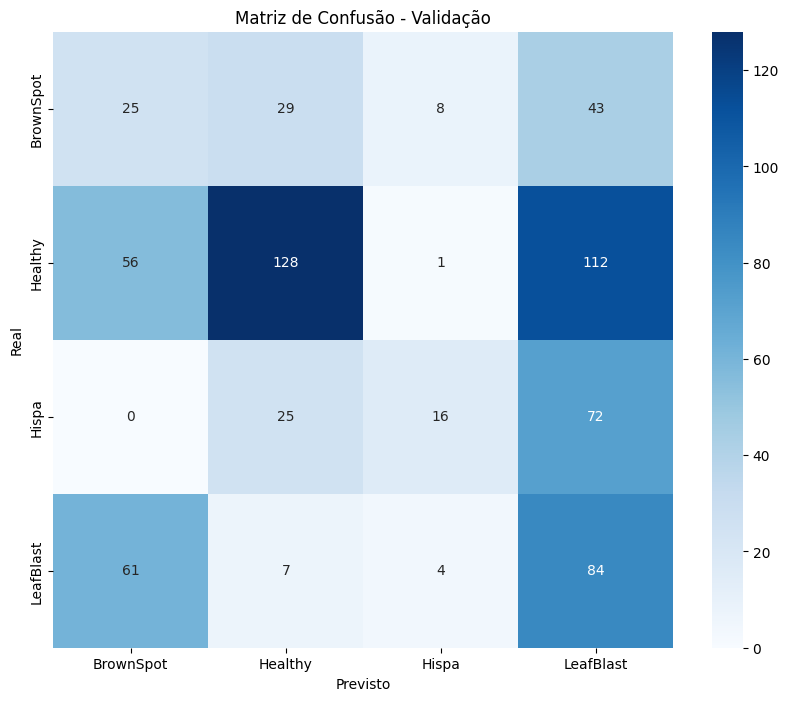

In [19]:
def evaluate_performance(model, loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    
    print("Gerando previsões para o conjunto de validação...")
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # 1. Relatório de Classificação (Precision, Recall, F1)
    print("\n--- Relatório de Classificação ---")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # 2. Matriz de Confusão
    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Previsto')
    plt.ylabel('Real')
    plt.title('Matriz de Confusão - Validação')
    plt.show()

# Executar a avaliação
evaluate_performance(trained_model, val_loader, device, class_names)

In [14]:
print(train_transform)
print(val_transform)

Compose(
    Resize(size=(224, 224), interpolation=bicubic, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomChoice(
    RandomRotation(degrees=[0.0, 0.0], interpolation=nearest, expand=False, fill=0)
    RandomRotation(degrees=[90.0, 90.0], interpolation=nearest, expand=False, fill=0)
    RandomRotation(degrees=[180.0, 180.0], interpolation=nearest, expand=False, fill=0)
    RandomRotation(degrees=[270.0, 270.0], interpolation=nearest, expand=False, fill=0)
)(p=None)
    ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1), saturation=None, hue=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Compose(
    Resize(size=(224, 224), interpolation=bicubic, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
